<div align="right">Python 2.7 Jupyter Notebook</div>

# Introduction to Funf

### Your completion of the notebook exercises will be graded based on your ability to do the following: 

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

#### Notebook objectives
By the end of this notebook, you will be expected to:
> 
  - Understand basic analysis of call and SMS log data; and
  - Perform mobility tracing using call record data.
    
####  List of exercises
>   - **Exercise 1**: Visualizing mobility trace patterns.
  - **Exercise 2**: Analysis and interpretation of behavior from mobility trace patterns (short range).
  - **Exercise 3**: Analysis and interpretation of behavior from mobility trace patterns (long range).

# Notebook introduction

Data from the following two publicly-available data sets will be used:
1. [Friends and Family](http://realitycommons.media.mit.edu/friendsdataset.html) by MIT Media Lab; and 
2. [Student-Life](http://studentlife.cs.dartmouth.edu/dataset.html) by Dartmouth College. 

The "Friends and Family" data set was generated using Funf. The "Student-Life" data set contains similar data and, while not created using it, Funf is quoted as one of its main sources of inspiration. You can read more about the data sets in the provided links.

> **Note**:
>[Funf](https://github.com/OpenSensing/funf-core-android) was introduced to you in the video content of this module. You are welcome to review the code on GitHub, and download and create your own application. Should you wish to do so, it is a good idea to start with this [Wi-Fi Scanner Tutorial](https://github.com/funf-org/funf-core-android/wiki/WifiScannerTutorial).

In the exercises that follow, you will familiarize yourself with some of the key features of the two data sets. The first exercise will focus on social features: call logs and SMS. In the second exercise, you will visualize the mobility trace for a user over a week. In the third exercise, you will extend the time period to a longer term.

There are numerous other features that can be explored in the data sets. Many of them are labeled as “technical”, as a certain degree of data wrangling is required before they can be used to analyze networks of social interactions.


The features demonstrated and contained in the datasets do not form a comprehensive list of all the possible sensor datasets. Additional options include accelerometer data used by fitness trackers, “screen on" status, and many others. When analyzing populations you will most likely start with the basics. You will then expand on these basics by merging additional features from other data sets (where available) that are potentially useful in addressing the particular problem that you are interested in.

<div class="alert alert-warning">
<b>Note</b>:<br>
It is strongly recommended that you save and checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.
</div>

#### Load libraries and set options
As usual, your Python toolbox consists of Pandas and NumPy. Folium is also added, as maps will be added to this notebook at a later stage.

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

## 1. Friends and Family: Call logs and SMS
You will run sample scripts to examine the datasets and visualize the timelines of various sensor readings. 

### 1.1 Analyze the call log of a single user
The "Friends and Family" dataset contains all users' calls in one file. One participant, "fa10-01-08", has been chosen as an example.

### 1.1.1 Analyze call log data

#### Data preparation

To start your analysis, you will:
- Load the dataset;
- Parse the datetime, and sort the dataset by this column;
- Filter the dataset to review a single user; and
- Examine the top rows in your new dataset.

In [2]:
# Load the dataset.
calls = pd.read_csv('../data/CallLog.csv')

# Parse datetimes using the Pandas function.
calls['local_time'] = pd.to_datetime(calls['local_time'])

# Index the dataset by the datetime column.
calls.set_index('local_time', inplace=True)

# Sort the dataset in place.
calls.sort_index(inplace=True)

# Set the user to be evaluated.
example_user = 'fa10-01-08'

# Create a subset of the data where participantID.A 
#     is the selected user using the copy method.
call_example = calls[calls['participantID.A'] == example_user].copy()

# Add a column where the week is derived from the datetime column.
call_example['week'] = call_example.index.map(lambda observation_timestamp: 
                                              observation_timestamp.week)

# Display the head of the new dataset.
call_example.head(3)

,participantID.A,participantID.B,type,duration,number.hash,week
local_time,,,,,,
2010-07-31 21:31:25,fa10-01-08,fa10-01-08,incoming+,NaN,84ae45baecadf7414ef18390f93c63c700b42e9,30
2010-08-06 09:22:55,fa10-01-08,fa10-01-08,incoming+,NaN,84ae45baecadf7414ef18390f93c63c700b42e9,31
2010-08-06 13:11:36,fa10-01-08,fa10-01-08,incoming+,NaN,84ae45baecadf7414ef18390f93c63c700b42e9,31


Review the unique types of records present in the dataset.

In [3]:
# Display the unique records for "type"
call_example.type.unique()

array(['incoming+', 'outgoing+', 'outgoing', 'incoming', 'missed'], dtype=object)

Next, create the weekly bins for the records of the types that you are interested in, and display the weekly summary. Missed calls have been excluded for the purpose of this exercise.

In [4]:
# Create a new variable, call_groups, containing call_example grouped by week.
call_groups = call_example.groupby(['week'], sort=False)

# Create a pandas dataframe.
call_weeks = pd.DataFrame(columns=['week', 'outgoing', 'incoming', 'total'])  

# Set the index for the new dataframe.
call_weeks.set_index('week', inplace=True)

# Next we create a summary table based on the observed types.
for week, group in call_groups:
    inc = 0
    out = 0
    
    try:
        inc += pd.value_counts(group.type)['incoming+']
    except KeyError:
        pass
    
    try:
        inc += pd.value_counts(group.type)['incoming']
    except KeyError:
        pass
    
    try:    
        out += pd.value_counts(group.type)['outgoing+']
    except KeyError:
        pass
    
    try:    
        out += pd.value_counts(group.type)['outgoing']
    except KeyError:
        pass
    
    call_weeks.loc[week] = [out, inc, out+inc]

# Display the head of our new dataset.
call_weeks.head(3)

,outgoing,incoming,total
week,,,
30,0.0,1.0,1.0
31,1.0,12.0,13.0
32,2.0,1.0,3.0


The calls per week can now be visualized using a barplot.

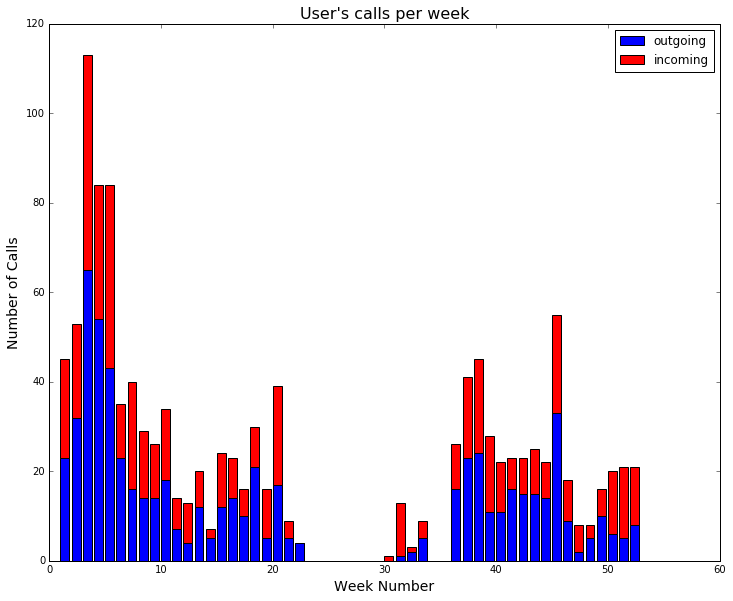

In [5]:
# Set plotting options
fig, ax = plt.subplots()
plt.tight_layout()

# Add outgoing calls to our plot
plt.bar(call_weeks.reset_index()['week'], call_weeks['outgoing'], 
        color='b', label='outgoing')

# Add incoming calls to our plot
plt.bar(call_weeks.reset_index()['week'], call_weeks['incoming'], 
        color='r', bottom=call_weeks['outgoing'], label='incoming')

# Plot formatting options
ax.set_xlabel("Week Number", fontsize=14)
ax.set_ylabel("Number of Calls", fontsize=14)
ax.set_title("User's calls per week", fontsize=16)
plt.legend()

### 1.1.2 Analyze SMS data

The exercise in the previous section will now be repeated with the SMS records for the same user.

In [6]:
# Load the dataset.
sms = pd.read_csv('../data/SMSLog.csv')

# Parse datetimes using the Pandas function.
sms['local_time'] = pd.to_datetime(sms['local_time'] )

# Index the dataset by the datetime column.
sms.set_index('local_time', inplace=True)

# Sort the dataset in place.
sms.sort_index(inplace=True)

# We have set the user to be evaluated in the call logs section and will 
#     reference the variable here. Create a subset of the data where 
#     participantID.A is the selected user using the copy method.
sms_example = sms[sms['participantID.A'] == example_user].copy()

# Add a column where the week is derived from the datetime column.
sms_example['week'] = sms_example.index.map(lambda observation_timestamp: 
                                            observation_timestamp.week)

# Display the head of the new dataset.
sms_example.head(3)

,participantID.A,participantID.B,type,number.hash,week
local_time,,,,,
2010-08-20 17:34:22,fa10-01-08,fa10-01-08,outgoing,84ae45baecadf7414ef18390f93c63c700b42e9,33
2010-09-08 11:12:05,fa10-01-08,NaN,incoming,bd7c809d7d47026e7390ba3c6b253d24efcbe8cf,36
2010-09-09 14:52:11,fa10-01-08,fa10-01-07,outgoing,35b04b6bc9e27f9637fb62451dd4ea625667bf05,36


Review the unique types of records present in the dataset.

In [7]:
sms_example.type.unique()

array(['outgoing', 'incoming'], dtype=object)

Next, create the weekly bins for the records of the types that you are interested in again (as was done in the previous section), and display the weekly summary.

In [8]:
# Create a new variable, sms_groups, containing call_example grouped by week.
sms_groups = sms_example.groupby(['week'], sort=False)

# Create a pandas dataframe.
sms_weeks = pd.DataFrame(columns=['week', 'outgoing', 'incoming', 'total'])  

# Set the index for the new dataframe.
sms_weeks.set_index('week', inplace=True)

# Next we create a summary table based on the observed types.
for week, group in sms_groups:
    try:
        inc = pd.value_counts(group.type)['incoming']
    except KeyError:
        inc = 0
        
    try:    
        out = pd.value_counts(group.type)['outgoing']
    except KeyError:
        out = 0
    sms_weeks.loc[week] = [out, inc, out+inc]

# Display the head of our new dataset.
sms_weeks.head(3)

,outgoing,incoming,total
week,,,
33,1.0,0.0,1.0
36,9.0,5.0,14.0
37,8.0,5.0,13.0


The SMSs per week can now be visualized using a barplot.

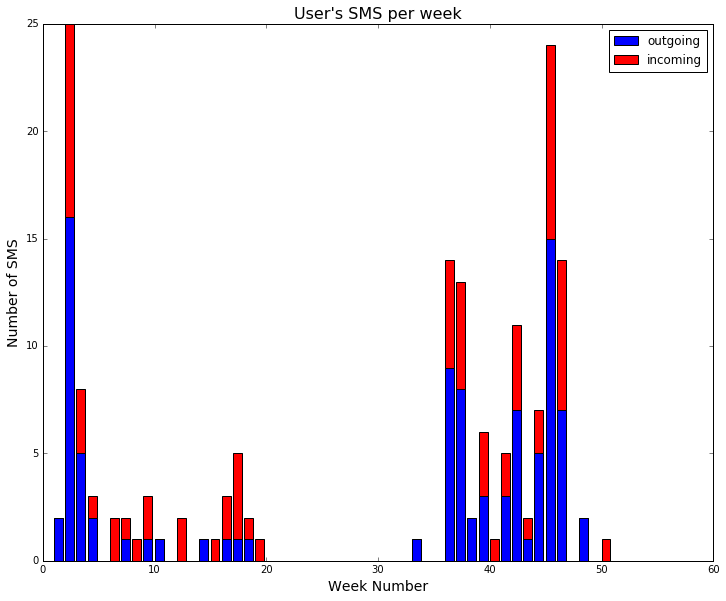

In [9]:
# Set plotting options
fig, ax = plt.subplots()
plt.tight_layout()

# Add outgoing sms to our plot
plt.bar(sms_weeks.reset_index()['week'], sms_weeks['outgoing'], 
        color='b', label='outgoing')

# Add incoming sms to our plot
plt.bar(sms_weeks.reset_index()['week'], sms_weeks['incoming'], 
        color='r', bottom=sms_weeks['outgoing'], label='incoming')

# Plot formatting options
ax.set_xlabel("Week Number", fontsize=14)
ax.set_ylabel("Number of SMS", fontsize=14)
ax.set_title("User's SMS per week", fontsize=16)
plt.legend()

> **Note**:

> You can select other users, and re-execute the cells above for both call and SMS logs to test your intuition about the differences in behaviour of students, should you wish to do so. This activity will not be graded.


# 2. Dartmouth: Location history example
You will run sample scripts to examine the dataset and visualize the timeline of the location data. The Dartmouth dataset has been selected for this example because the locations in the "Friends and Family" dataset are encrypted and not suitable for use in this visual exercise.

### 2.1 Analyze the location of a single user
The "Student-Life" data set contains separate files for each of the users. User 31 has been selected for this example.

Data preparation will need to be completed before your analysis can start. You need to: 
- Load the dataset;
- Parse the datetime; and,
- Sort it by this column. 

The dataset will then need to be filtered to review a single user. 

In [10]:
# Import the dataset and display the head.
loc = pd.read_csv('../data/dartmouth/location/gps_u31.csv')
loc.head(3)

,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,1364407095,network,wifi,22.995,43.706616,-72.287025,0.0,0.0,0.0,NaN
1,1364408295,network,wifi,22.667,43.706599,-72.287036,0.0,0.0,0.0,NaN
2,1364411158,network,wifi,20.000,43.706584,-72.287006,0.0,0.0,0.0,NaN


In the output above, the GPS coordinates are visible, and the dataset is very similar in structure to the "Friends and Family" dataset. In order to be able to work with this data as a chronological location trace, it needs to be indexed with sorted timestamps (in human-readable ISO format). The next step is to review the summary statistics of the re-indexed DataFrame.

In [11]:
# Parse the dates.
loc['time'] = pd.to_datetime(loc['time'], unit='s')

# Set and reindex.
loc.set_index('time', inplace=True)
loc.sort_index(inplace=True)

# Display the head.
loc.head(3)

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
time,,,,,,,,,
2013-03-27 17:58:15,network,wifi,22.995,43.706616,-72.287025,0.0,0.0,0.0,NaN
2013-03-27 18:18:15,network,wifi,22.667,43.706599,-72.287036,0.0,0.0,0.0,NaN
2013-03-27 19:05:58,network,wifi,20.000,43.706584,-72.287006,0.0,0.0,0.0,NaN


In [12]:
# Retrieve the start and end dates for the dataset and print the output.
start = pd.to_datetime(loc.index, unit='s').min()
end   = pd.to_datetime(loc.index, unit='s').max()
print ("Data covers {} between {} and {}".format(end - start, start, end))

# Calculate the median interval between observations and print the output.
median_interval = pd.Series(pd.to_datetime(loc.index, 
                                               unit='s')).diff().median().seconds / 60
print ("It has {} datapoints sampled with median interval of {} minutes."
       .format(len(loc), median_interval))

Data covers 63 days 17:08:07 between 2013-03-27 17:58:15 and 2013-05-30 11:06:22
It has 4203 datapoints sampled with median interval of 20 minutes.


Next, the step to add a column with the week will be repeated, and the DataFrame will be grouped by this column.

In [13]:
# Add a column containing the week.
loc['week'] = loc.index.map(lambda observation_timestamp: 
                            observation_timestamp.week)
loc.head(3)

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,week
time,,,,,,,,,,
2013-03-27 17:58:15,network,wifi,22.995,43.706616,-72.287025,0.0,0.0,0.0,NaN,13
2013-03-27 18:18:15,network,wifi,22.667,43.706599,-72.287036,0.0,0.0,0.0,NaN,13
2013-03-27 19:05:58,network,wifi,20.000,43.706584,-72.287006,0.0,0.0,0.0,NaN,13


Review the number of observations per week by grouping the data by the column added in the previous cell.

In [14]:
# Group by week and review the output.
week_gr = loc.groupby('week', axis=0)
pd.DataFrame(week_gr.size(), columns=['# of observations'])

,# of observations
week,
13,300
14,503
15,500
16,504
17,504
18,500
19,492
20,474
21,420


Next, the data will be plotted on a map. Some additional steps to prepare the data are required before this can be done. 

The coordinates from the location DataFrame need to be extracted into a simpler format; one without indexes, column names, and unnecessary columns. This example will work on the weekly groupings and use Pandas' DataFrame ``df.as_matrix()`` method, which returns a raw NumPy matrix.

In [15]:
weekly_travels = {}

for week, points in week_gr:
    weekly_travels[week] = points[['latitude', 'longitude']].as_matrix() 

> **Note**: 

> The Python visualization library, Folium, was introduced in an earlier notebook. However, it is good to know that the center location and starting zoom level are options that you will need to manually set. In many cases, your analysis will be centered around a known coordinate, in which case, you can manually update the location. In other cases, you will need to calculate the position based on your available data.

Now you can plot the data. The following example looks at a specific week.

In [28]:
# Set the center of the map and the zoom level. 
map_week15 = folium.Map(location=[43.706607,-72.287041], zoom_start=11)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[15], color='blue', weight=7, 
                opacity=0.5).add_to(map_week15)
map_week15

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions
> Copy the code in the previous cell, and change Week 15 to Week 20 to produce the mobility trace for Week 20. You need to replace "map_week15" with "map_week20", and retrieve Element 20 from the variable "weekly_travels".

**Optional:**
>If you want to, you can attempt to recenter the map, and specify a different zoom level to produce a map that is better suited to the visualization. (The answer is demonstrated in the mobility trace for all of the user's data further down in this notebook.)

In [27]:
# Set the center of the map and the zoom level. 
map_week20 = folium.Map(location=[43,-71.85], zoom_start=8)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[20], color='blue', weight=3, 
                opacity=0.5).add_to(map_week20)
map_week20

<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 2 Start.</b>
</div>

### Instructions
> When comparing the visual representation of the two weeks, you will see that the patterns are very similar. Provide a high-level summary of the person's mobility in the cell below.

> Here are some questions to guide your answer:
- How many places do you think the person visited during Week 15?
- Compared to other weeks, is this person's behavior predictable?
- Is this representative of general behavior, or is the number of places visited lower or higher than you expected?

It appears the user visited 4 locations during week 15. When compared to week 20, we see that the travel habits of our person are relativly stable. The user follows the same pattern of travel every week, suggesting work/family/etc.

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 3 Start.</b>
</div>

### Instructions

> What can you conclude from comparing the person's mobility from single weeks to the full data set? Provide a high-level summary in the cell below.

There are several things to be learned from this comparison. The first being a contrast of the habit vs exploration patterns, or "foraging" behavior mentioned last module. We can see which travel data points are regularly executed, and which are spontaneous or unexpected. Next, we can compare the *number* of data points in order to gain an activity comparison week by week vs average.

<br>
<div class="alert alert-info">
<b>Exercise 3 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 3. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the Online Campus.

## 4. References
1. Aharony, Nadav, Wei Pan, Cory Ip, Inas Khayal, and Alex Pentland. 2011. “SocialfMRI: Investigating and shaping social mechanisms in the real world.” Pervasive and Mobile Computing 7: 643-659. 
2. Wang, Rui, Fanglin Chen, Zhenyu Chen, Tianxing Li, Gabriella Harari, Stefanie Tignor, Xia Zhou, Dror Ben-Zeev, and Andrew T. Campbell. 2014. “StudentLife: Assessing Mental Health, Academic Performance and Behavioral Trends of College Students using Smartphones.” Proceedings of the ACM Conference on Ubiquitous Computing. 2014.